In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras import ops

In [3]:
df_merged = pd.read_pickle('data/df_merged_cleaned.pkl')
df_ratings = pd.read_pickle('data/df_ratings_100k.pkl')

In [4]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

## Ratings Preprocessing

In [5]:
df_ratings.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"


In [6]:
# Make sure that the timestamp is in seconds
df_ratings['timestamp'] = df_ratings['timestamp'].astype('int64') // 10**9

# Keep only relevant columns
df_ratings = df_ratings[['userId', 'movieId', 'rating', 'timestamp']]

# Make userId the index
#df_ratings.set_index('userId', inplace=True)

# Delete index
df_ratings.reset_index(drop=True, inplace=True)

df_ratings.head()

,userId,movieId,rating,timestamp
0,128365,1037,0.5,1255947037
1,34770,27316,0.5,1149930873
2,108700,307,0.5,1273699572
3,162680,73929,0.5,1448216549
4,141941,4308,0.5,1149916907


## Movies Preprocessing

In [7]:
df_merged.head()

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,1,1,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America]
1,2,0,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America]
2,3,1,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America]
3,4,0,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America]
4,5,1,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America]


In [8]:
# Keep only relevant columns
df_movies = df_merged[['movieId', 'title', 'genre_extracted']]

df_movies.head()

,movieId,title,genre_extracted
0,1,Toy Story,"[Animation, Comedy, Family]"
1,2,Jumanji,"[Adventure, Fantasy, Family]"
2,3,Grumpier Old Men,"[Romance, Comedy]"
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,[Comedy]


In [12]:
# Function to transform list of genres into a pipe-separated string
def transform_genre(genres_list):
    # Join list elements with a pipe
    return '|'.join(genres_list)

# Apply the transformation
df_movies['genres'] = df_movies['genre_extracted'].apply(transform_genre)

# drop the genre_extracted column
df_movies.drop('genre_extracted', axis=1, inplace=True)

# Display the transformed DataFrame
df_movies.head()

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_62004/2266882199.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['genres'] = df_movies['genre_extracted'].apply(transform_genre)
/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_62004/2266882199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies.drop('genre_extracted', axis=1, inplace=True)


,movieId,title,genres
0,1,Toy Story,Animation|Comedy|Family
1,2,Jumanji,Adventure|Fantasy|Family
2,3,Grumpier Old Men,Romance|Comedy
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [13]:
user_ids = df_ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df_ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df_ratings["user"] = df_ratings["userId"].map(user2user_encoded)
df_ratings["movie"] = df_ratings["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df_ratings["rating"] = df_ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df_ratings["rating"])
max_rating = max(df_ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 55588, Number of Movies: 9494, Min rating: 0.5, Max rating: 5.0


## Prepare data for training

In [14]:
df = df_ratings.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model

In [15]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

## Train the model

In [16]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.6853 - val_loss: 0.6597
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.6463 - val_loss: 0.6586
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.6189 - val_loss: 0.6541
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.6188 - val_loss: 0.6518
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.6227 - val_loss: 0.6492


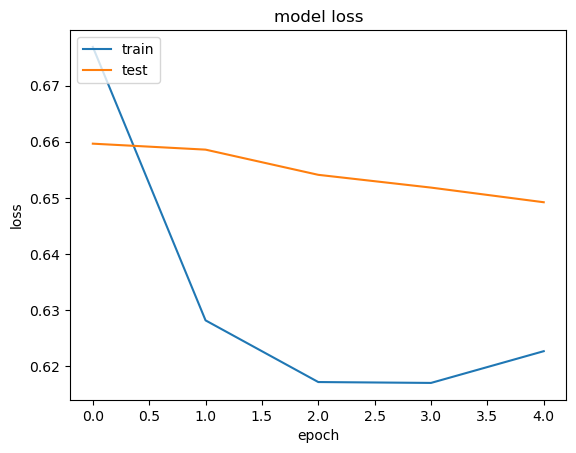

In [17]:
# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Make movie recommendations

In [18]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = df_movies[
    ~df_movies["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = df_movies[df_movies["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = df_movies[df_movies["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
Showing recommendations for user: 160569
Movies with high ratings from user
--------------------------------
Highlander : Adventure|Action|Fantasy
Being John Malkovich : Fantasy|Drama|Comedy
Born American : Drama|Action
Bridget Jones's Diary : Comedy|Romance|Drama
Eastern Promises : Thriller|Crime|Mystery
--------------------------------
Top 10 movie recommendations
--------------------------------
The Usual Suspects : Drama|Crime|Thriller
Pulp Fiction : Thriller|Crime
The Shawshank Redemption : Drama|Crime
Schindler's List : Drama|History|War
The Silence of the Lambs : Crime|Drama|Thriller
The Godfather : Drama|Crime
The Princess Bride : Adventure|Family|Fantasy|Comedy|Romance
Raiders of the Lost Ark : Adventure|Action
GoodFellas : Drama|Crime
The Godfather: Part II : Drama|Crime
